# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [27]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

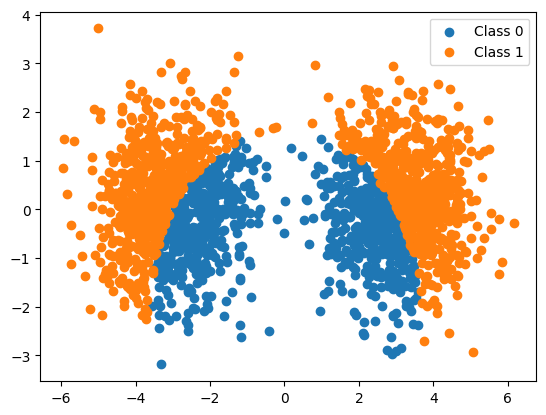

In [29]:
# Visualize the data
# TODO
plt.scatter(data[labels==0, 0], data[labels==0, 1], label='Class 0')
plt.scatter(data[labels==1, 0], data[labels==1, 1], label='Class 1')
plt.legend()
plt.show()


I think a linear model cannot separate the classes well.

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [30]:
class Expert(nn.Module):
  # TODO
  def __init__(self):
    super(Expert, self).__init__()
    self.linear = nn.Linear(2, 1)
  def forward(self, x):
    x = self.linear(x)
    return x



## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [31]:
class GatingNetwork(nn.Module):
  # TODO
  def __init__(self, num_experts):
    super(GatingNetwork, self).__init__()
    self.linear = nn.Linear(2, num_experts)
  def forward(self, x):
    x = self.linear(x)
    return F.softmax(x, dim=1)

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [32]:
class MixtureOfExperts(nn.Module):
  # TODO
    def __init__(self, num_experts=2):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([Expert() for i in range(num_experts)])
        self.gating = GatingNetwork(num_experts)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        g = self.gating(x)
        y_pred = torch.zeros(x.shape[0], 1)
        for i in range(len(self.experts)):
            y_pred += g[:, i].view(-1, 1) * self.experts[i](x)
        y_pred = self.sigmoid(y_pred)
        return y_pred
        
        


## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [57]:
# Define the model, loss, and optimizer
model = MixtureOfExperts()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 6000
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    y_pred = model(data_tensor)
    loss = criterion(y_pred, labels_tensor)
    acc = ((y_pred > 0.5) == labels_tensor).sum().float() / len(labels_tensor)


    # Backward pass and optimization
    # TODO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    # TODO
    scheduler.step()
    # Print out the loss and accuracy
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {acc.item()}')

Epoch: 0, Loss: 0.7071024179458618, Accuracy: 0.4950000047683716
Epoch: 1000, Loss: 0.15056605637073517, Accuracy: 0.9399999976158142
Epoch: 2000, Loss: 0.14905992150306702, Accuracy: 0.9409999847412109
Epoch: 3000, Loss: 0.14902199804782867, Accuracy: 0.9415000081062317
Epoch: 4000, Loss: 0.14902184903621674, Accuracy: 0.9415000081062317
Epoch: 5000, Loss: 0.14902184903621674, Accuracy: 0.9415000081062317


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

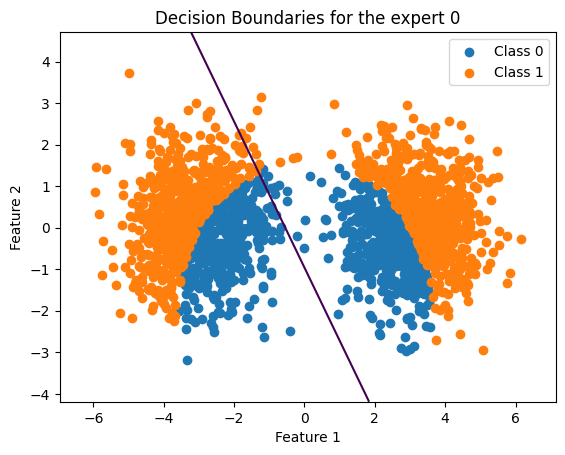

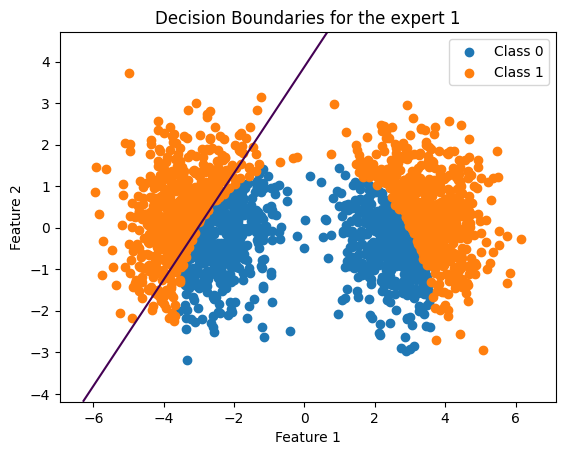

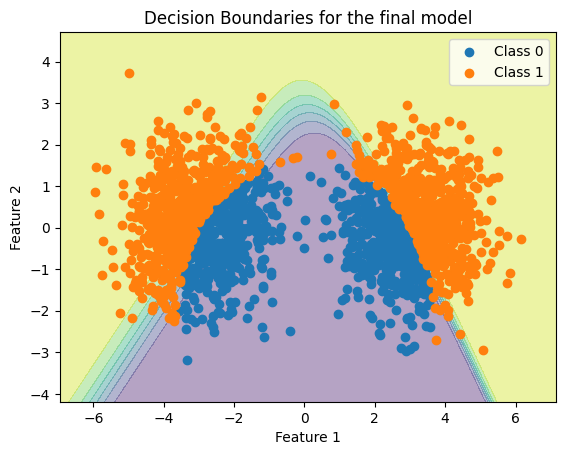

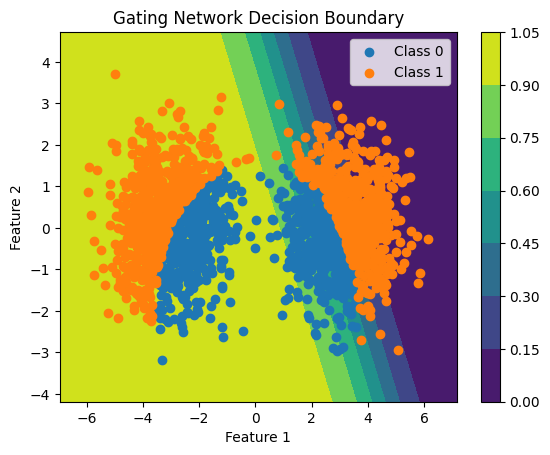

In [58]:
def grid(x, y, model):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.detach().numpy().reshape(xx.shape)
    return xx, yy, Z


def plot_decision_boundaries(x, y, model):
    xx, yy, Z = grid(x, y, model)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(x[y==0, 0], x[y==0, 1], label='Class 0')
    plt.scatter(x[y==1, 0], x[y==1, 1], label='Class 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries for the final model')
    plt.legend()

def plot_decision_boundary_experts(x, y, model):
    i = 0
    for expert in model.experts:
        xx, yy, Z = grid(x, y, model)
        plt.scatter(x[y==0, 0], x[y==0, 1], label='Class 0')
        plt.scatter(x[y==1, 0], x[y==1, 1], label='Class 1')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        if i == 0:
            plt.title('Decision Boundaries for the expert 0')
            i+=1
        else: 
            plt.title('Decision Boundaries for the expert 1')

        plt.legend()
        xx, yy, Z = grid(x, y, expert)
        plt.contour(xx, yy, Z, levels=[1])
        plt.show()

def plot_decision_boundary_gating(x, y, model):
    xx, yy = np.meshgrid(np.linspace(x[:, 0].min() - 1, x[:, 0].max() + 1, 100),
                         np.linspace(x[:, 1].min() - 1, x[:, 1].max() + 1, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    with torch.no_grad():
        grid_tensor = torch.from_numpy(grid_points).float()
        gating_output = model.gating(grid_tensor).detach().numpy()

    Z_gating = gating_output.reshape(*xx.shape, -1)

    for i in range(Z_gating.shape[2]):
        plt.contourf(xx, yy, Z_gating[:, :, i]) 
    plt.colorbar()
    plt.scatter(x[y == 0, 0], x[y == 0, 1],  label='Class 0')
    plt.scatter(x[y == 1, 0], x[y == 1, 1],  label='Class 1')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Gating Network Decision Boundary')
    plt.legend()
    plt.show()


plot_decision_boundary_experts(data, labels, model)
plt.show()

plot_decision_boundaries(data, labels, model)
plt.show()

model.eval()
plot_decision_boundary_gating(data, labels, model)



Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two? 

Answer: The two experts have different performance. In my scenario, Expert 0 has bad performance in classifying Class 1. Conversely, Expert 1 has better performance, it classified my class0 successfully. The gating network then establishes its decision boundary on the right half of the plot, accurately classifying Class 0 instances within that region. And the final model is perform well.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)

